In [ ]:
#VGG19
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model

# 加載圖片並保留比例
def load_and_preprocess_image(image_path, max_size=512):
    img = load_img(image_path)
    original_size = img.size  # 保留原始大小 (width, height)

    # 縮放到 max_size 以內，保持比例
    scale = max_size / max(original_size)
    new_size = (int(original_size[0] * scale), int(original_size[1] * scale))
    img = img.resize(new_size)

    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.vgg19.preprocess_input(img_array), original_size, new_size

# 反預處理，將 VGG19 預處理的圖片轉回正常範圍
def deprocess_image(img_array, original_size):
    img_array = img_array.reshape((img_array.shape[1], img_array.shape[2], 3))
    img_array[:, :, 0] += 103.939
    img_array[:, :, 1] += 116.779
    img_array[:, :, 2] += 123.68
    img_array = img_array[:, :, ::-1]  # BGR to RGB
    img_array = np.clip(img_array, 0, 255).astype('uint8')
    return Image.fromarray(img_array).resize(original_size)  # 恢復原始大小

# 定義風格轉移的損失
def gram_matrix(tensor):
    channels = int(tensor.shape[-1])
    vectorized = tf.reshape(tensor, [-1, channels])
    gram = tf.matmul(tf.transpose(vectorized), vectorized)
    return gram

def style_loss(style, combination):
    return tf.reduce_mean(tf.square(gram_matrix(style) - gram_matrix(combination)))

def content_loss(base_content, combination):
    return tf.reduce_mean(tf.square(combination - base_content))

def total_variation_loss(image):
    x_var = image[:, :-1, 1:, :] - image[:, :-1, :-1, :]
    y_var = image[:, 1:, :-1, :] - image[:, :-1, :-1, :]
    return tf.reduce_mean(tf.square(x_var)) + tf.reduce_mean(tf.square(y_var))

# 執行風格轉移
def run_style_transfer(content_path, style_path, iterations=1000, content_weight=1e3, style_weight=1e-2, max_size=512):
    # 加載內容和風格圖片，保留原始比例
    content_image, original_size, new_size = load_and_preprocess_image(content_path, max_size)
    style_image, _, _ = load_and_preprocess_image(style_path, max_size)

    # 生成圖片（初始化為內容圖片）
    combination_image = tf.Variable(content_image, dtype=tf.float32)

    # 加載 VGG19 模型
    vgg = vgg19.VGG19(weights='imagenet', include_top=False)
    vgg.trainable = False
    outputs_dict = {layer.name: layer.output for layer in vgg.layers}
    feature_extractor = Model(inputs=vgg.input, outputs=outputs_dict)

    # 定義特徵層
    content_layer = 'block5_conv2'
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

    # 提取內容和風格特徵
    content_features = feature_extractor(content_image)[content_layer]
    style_features = [feature_extractor(style_image)[layer] for layer in style_layers]

    # 優化器
    opt = tf.keras.optimizers.Adam(learning_rate=5.0)

    @tf.function
    def compute_loss_and_grads():
        with tf.GradientTape() as tape:
            combination_features = feature_extractor(combination_image)
            combination_content = combination_features[content_layer]
            combination_styles = [combination_features[layer] for layer in style_layers]

            # 計算損失
            c_loss = content_loss(content_features, combination_content) * content_weight
            s_loss = tf.add_n([style_loss(style_features[i], combination_styles[i]) for i in range(len(style_layers))])
            s_loss *= style_weight
            tv_loss = total_variation_loss(combination_image)
            loss = c_loss + s_loss + tv_loss
        grads = tape.gradient(loss, combination_image)
        return loss, grads

    # 優化過程
    for i in range(iterations):
        loss, grads = compute_loss_and_grads()
        opt.apply_gradients([(grads, combination_image)])
        if i % 100 == 0:
            print(f"Iteration {i}: loss={loss.numpy()}")

    # 生成最終圖片
    final_image = combination_image.numpy()
    return deprocess_image(final_image, original_size)



Iteration 0: loss=1.6040181358395392e+16
Iteration 100: loss=119641372360704.0
Iteration 200: loss=47584492126208.0
Iteration 300: loss=27900430516224.0
Iteration 400: loss=19501357727744.0
Iteration 500: loss=13744374546432.0
Iteration 600: loss=14310105415680.0
Iteration 700: loss=8727308533760.0
Iteration 800: loss=6541237288960.0
Iteration 900: loss=5804166479872.0


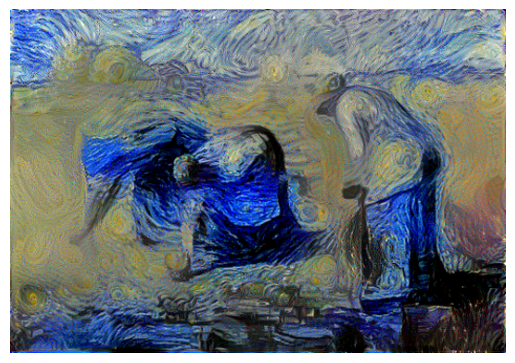

In [ ]:
from PIL import Image

# 設定內容圖片和風格圖片的路徑
content_path = '/content/orig.jpeg'  # 內容圖片
style_path = '/content/starry_night.jpg'  # 梵高畫風圖片

# 執行風格轉移
result_image = run_style_transfer(content_path, style_path)

# 顯示結果
plt.imshow(result_image)
plt.axis('off')
plt.show()